### Model assessment: LOO-CV for factory data with Stan (6p)

Use leave-one-out cross validation (LOO-CV) to assess the predictive performance of the pooled, separate and hierarchical Gaussian models for the factory dataset (see the second exercise in Assignment 5). Use Stan for fitting the models, and the provided PSIS-LOO (Pareto smoothed importance sampling LOO) code for computing the approximate LOO-CV given the posterior samples provided by Stan. Your results should include:

 * PSIS-LOO values, the effective number of parameters peff, and the k-values for each of the three models
 * an assessment of whether there are differences between the models, and if so, which model should be selected according to PSIS-LOO
 
Remember also to comment on the results. Hints and further advice:

 * In all the three models, use uniform priors for all the parameters to standardize the model assessment results, making the grading easier.
 * In the hierarchical model, use the same measurement deviation σ for all the machines. This is reasonable, since there are so few measurements per machine, so learning the deviations separately for each machine is difficult. If you want, you can also compute the PSIS-LOO value for the hierarchical model with different σj for each machine and see the effect in the estimated predictive performance (this is not, however, required for full points). For the separate model, you should still use different σj for each machine.
 * In order to use the psisloo-function, you need to compute the log-likelihood values for each observation and for all the posterior samples. This can be done in the generated quantities block; for a demonstration, see the Gaussian linear model for Kilpisjärvi data in the Matlab Stan examples.
 * It is reasonable to visualize the k-values for each model, so that you can easily see how many of these values fall in the range 0.5 < k < 1 or k > 1 to assess the reliability of the PSIS-LOO estimate for each of the models.
 * The estimated effective number of parameters in the model can be computed from equation (7.15) in the book, where lppdloo-cv is the PSIS-LOO value (first output argument of psisloo) and lppd is given by equation (7.5) in the book.
 * PSIS-LOO is a recently developed method for approxmating the exact LOO and is thus not in BDA3. For more information, see the lecture slides and the original paper by Vehtari, Gelman and Gabry (2015) on arXiv http://arxiv.org/pdf/1507.04544v2

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from psis import psisloo
import numpy as np
import pystan

plt.style.use('ggplot')
plt.rc('figure', figsize=(16, 4))
plt.rc('font', size=16)

y = np.loadtxt('../ex5/factory.txt')
print y

[[  83.  117.  101.  105.   79.   57.]
 [  92.  109.   93.  119.   97.   92.]
 [  92.  114.   92.  116.  103.  104.]
 [  46.  104.   86.  102.   79.   77.]
 [  67.   87.   67.  116.   92.  100.]]


In [50]:
def p_eff(lppd_loo_cv, log_like):
    """
    lppd_loo_cv: float
    log_like: (n x m) log-likelihood of m data points, given n posterior samples.
    """
    lppd = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
    return lppd - lppd_loo_cv

### Separate model

In [4]:
data_separate = {
    'J': y.shape[0],
    'K': y.shape[1],
    'y': y
}
code_separate = """
data {
    int<lower=1> J; // number of data points
    int<lower=1> K; // number of groups 
    matrix[J,K]  y; // measurements
}
parameters {
    vector[K] mu; // mean
    vector<lower=0>[K] sigma; // std
}
model {
    for (k in 1:K) {
      y[:,k] ~ normal(mu[k], sigma[k]);
    }
}
generated quantities {
    matrix[J,K] log_like;

    for(j in 1:J)
        for (k in 1:K)
            log_like[j,k] <- normal_log(y[j,k], mu[k], sigma[k]);
}
"""
fit_separate = pystan.stan(model_code=code_separate, data=data_separate, iter=3000, chains=20)
params_separate = fit_separate.extract()
print fit_separate

Inference for Stan model: anon_model_211c5fad6404f77f6ba1b5cf3d50eb76.
20 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=30000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]          76.04    0.26  16.83   43.5  68.18  76.05   83.7 108.41 4303.0    1.0
mu[1]         106.09    0.14   9.74  86.83 101.52 106.14 110.71 125.32 4683.0    1.0
mu[2]          87.86    0.14  10.22  67.68  82.77  87.83  92.91 108.81 5101.0    1.0
mu[3]         111.61    0.08   6.02  99.29 108.71 111.66  114.6 123.66 5129.0    1.0
mu[4]           90.0    0.18   9.79  71.73  85.65  89.96  94.27 108.49 2884.0   1.01
mu[5]          86.35    0.26  16.39  55.04  78.57  86.07   93.6 119.17 3999.0    1.0
sigma[0]       31.14    0.35  21.52  12.79  19.28  25.33  35.59  84.21 3777.0    1.0
sigma[1]       18.63    0.19  12.34   7.74  11.67  15.33  21.28  49.86 4255.0    1.0
sigma[2]       20.02    0.18  12.72   8.38  

Sum PSIS-LOO LPD: -132.357732, p-eff: 9.803089 


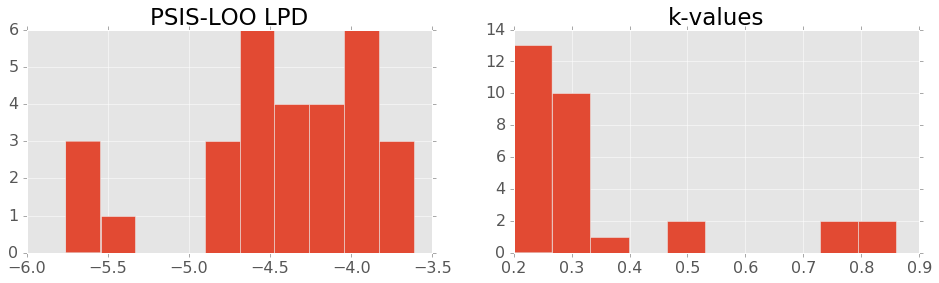

In [63]:
ll = params_separate['log_like'].reshape(30000, -1)
loo, loos, ks = psisloo(ll)

plt.subplot(121)
_=plt.hist(loos)
_=plt.title('PSIS-LOO LPD')
plt.subplot(122)
_=plt.hist(ks)
_=plt.title('k-values')
print "Sum PSIS-LOO LPD: %f, p-eff: %f " % (loo, p_eff(loo, ll))

### Combined model

In [52]:
data_combined = {
    'J': y.size,
    'y': y.flatten()
}
code_combined = """
data {
    int<lower=1> J; // number of data points
    vector[J] y; // measurements
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[J] log_like;

    for(j in 1:J)
        log_like[j] <- normal_log(y[j], mu, sigma);
}
"""
fit_combined = pystan.stan(model_code=code_combined, data=data_combined, iter=3000, chains=20)
params_combined = fit_combined.extract()
print fit_combined

Inference for Stan model: anon_model_0eb95ce5f999fb6e61f8ede581120a4d.
20 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=30000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            92.88    0.04   3.47  85.97  90.61   92.9  95.15  99.68 7472.0    1.0
sigma         18.81    0.03   2.62  14.55  16.95   18.5  20.31  24.81 7211.0    1.0
log_like[0]   -4.01  1.7e-3   0.14   -4.3   -4.1   -4.0  -3.91  -3.75 7277.0    1.0
log_like[1]   -4.73  3.0e-3   0.26  -5.32  -4.88   -4.7  -4.54   -4.3 7831.0    1.0
log_like[2]   -3.96  1.6e-3   0.14  -4.25  -4.05  -3.95  -3.86  -3.71 7211.0    1.0
log_like[3]   -4.08  1.7e-3   0.15  -4.39  -4.17  -4.07  -3.98  -3.82 7406.0    1.0
log_like[4]   -4.15  1.8e-3   0.15  -4.47  -4.25  -4.14  -4.04  -3.87 7593.0    1.0
log_like[5]   -5.78  5.9e-3   0.52  -6.95  -6.09  -5.73  -5.41  -4.94 7746.0    1.0
log_like[6]   -3.86  1.7e-3   0.14  -4.15  -3.95  -3.

Sum PSIS-LOO LPD: -130.953165, p-eff: 2.002530 


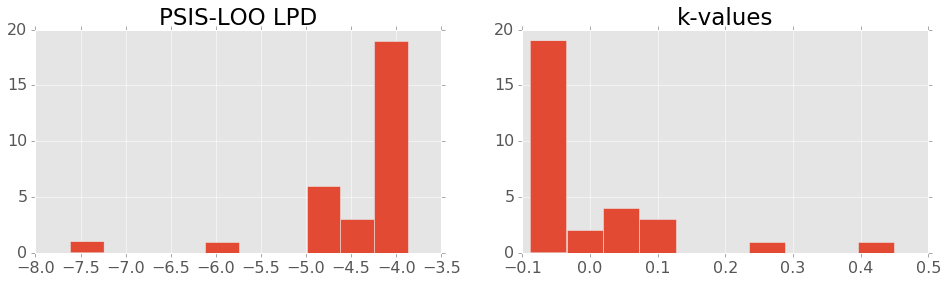

In [64]:
ll = params_combined['log_like'].reshape(30000, -1)
loo, loos, ks = psisloo(ll)

plt.subplot(121)
_=plt.hist(loos)
_=plt.title('PSIS-LOO LPD')
plt.subplot(122)
_=plt.hist(ks)
_=plt.title('k-values')
print "Sum PSIS-LOO LPD: %f, p-eff: %f " % (loo, p_eff(loo, ll))

### Hierarchical model

In [57]:
data_hierarchical = {
    'J': y.shape[0],
    'K': y.shape[1],
    'y': y
}
code_hierarchical = """
data {
    int<lower=1> J; // number of data points
    int<lower=1> K; // number of groups 
    matrix[J,K]  y; // measurements
}
parameters {
    real          mu0;
    real<lower=0> sigma0;
    vector[K]     mu;     // group means
    real<lower=0> sigma;  // shared std
}
model {
    for (k in 1:K){
      mu[k] ~ normal(mu0, sigma0);
      y[:,k] ~ normal(mu[k], sigma);    
    }
}
generated quantities {
    matrix[J,K] log_like;

    for(j in 1:J)
        for (k in 1:K)
            log_like[j,k] <- normal_log(y[j,k], mu[k], sigma);
}
"""
fit_hierarchical = pystan.stan(model_code=code_hierarchical, data=data_hierarchical, iter=3000, chains=20)
params_hierarchical = fit_hierarchical.extract()
print fit_hierarchical

Inference for Stan model: anon_model_3c1576bd8e91fb2761426f2c2ff27280.
20 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=30000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0             93.0     0.1   7.97  77.16  88.75  92.99  97.24 108.85 6305.0    1.0
sigma0         15.88    0.14   9.53   4.32   10.0  13.87  19.32  39.13 4700.0    1.0
mu[0]          80.06     0.1    6.9  66.55  75.38  80.01  84.78  93.45 5056.0    1.0
mu[1]         103.07    0.09   6.62  90.12  98.61 103.09 107.42 116.07 5684.0    1.0
mu[2]          89.08    0.07   6.19  76.76  85.01  89.21  93.15 101.17 7960.0    1.0
mu[3]         107.12    0.11   6.95  93.34  102.5 107.28 111.89 120.51 3861.0    1.0
mu[4]          90.78    0.07   6.12  78.55  86.78  90.87  94.87 102.68 8573.0    1.0
mu[5]          87.64    0.07   6.13  75.53  83.52  87.73  91.71  99.48 8156.0    1.0
sigma          15.25    0.03   2.38  11.44  

Sum PSIS-LOO LPD: -126.933453, p-eff: 5.745502 


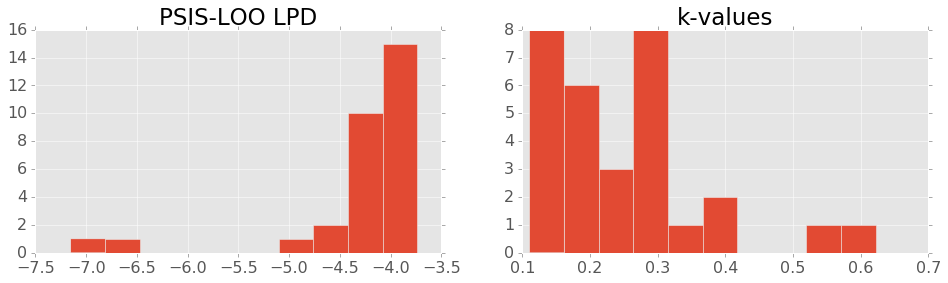

In [65]:
ll = params_hierarchical['log_like'].reshape(30000, -1)
loo, loos, ks = psisloo(ll)

plt.subplot(121)
_=plt.hist(loos)
_=plt.title('PSIS-LOO LPD')
plt.subplot(122)
_=plt.hist(ks)
_=plt.title('k-values')
print "Sum PSIS-LOO LPD: %f, p-eff: %f " % (loo, p_eff(loo, ll))

### Conclusion

For all the models the Rhat's are close to 1, and the k-values are below 1, and most below 0.5, so the models are converged and the PSIS-LOO values are good estimates of the real LOO LPD. Since the hierarchical model has the highest PSIS-LOO LPD, this is the better model of the data.